Problem statement : The objective of this notebook is to model stock prices of a new generation stock, Robinhood Markets Inc (HOOD).

About the stock : HOOD is listed on Nasdaq on Jul 29th, 2021.

Methodology  : Am starting with simple single linear regression model, input here is discreate variable. Then, moved to continuous distributions like normal and log normal distributions. Finally, stock prices are modelled via Monte Carlo Simulation.

Model 1: One factor linear regression with regular 1 day returns, Y = α + β*x.
To calculate expected value of Y, my model, E(Y) =  α + β* E(x).
As HOOD does not have long time series (listed recently), regressor is returns from NASADQ index. Calculated R-squared to measure goodness of the fit.

Model 2: One factor linear regression with  1 day  log returns. Popular expected returns models like GBM assume log returns due to properties of logarithms.  Single factor regression model remains same otherwise. To get a view on goodness of fit R^2 is calculated.

Model 3: Normal distribution with 1 day regular return.
A random variable $Z$ with a standard normal distribution is described by the following p.d.f.

$$ p(z) = \frac{1}{\sqrt{2\pi}} e^{-z^2 / 2}. $$

It is defined for all real values $z$, from $-\infty$ to $\infty$.
$$ X = \mu + \sigma Z $$$$ $$ is $\text{Normal}(\mu, \sigma)$

To test normality, p value is calculated.

Model 4: Log normal distribution. Here I have taken 1 day log returns, rest of the model remains same. To test normality, p value is calculated.


Model 5: Monte Carlo simulation. If a stock exhibit jumps, fat tails, path dependent payoffs etc analytical methods are not very useful. In such scenarios, natural approach is to use powerful simulation approach.
Stock price follows Geometric Brownian motion then,

dS/S  =  μ*dt + σ*dw. This model is rerun over large number of trials to get closing price for a future date

In [1]:
# importing lib
from pandas_datareader import data as pdr
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats


In [2]:
# Download data from Yahoo site for Nasdaq composite index and Robinhood Markets Inc and store in a dataframe
# start date of 29-Jul-2021 is set as HOOD (symbol of Robinhood Markets Inc on Nasdaq index) was listed on this CoB
yf.pdr_override()
y_symbols = ['NDX', 'HOOD']
from datetime import datetime
startdate = datetime(2021,7,29)
enddate = datetime(2022,12,31)
data = pdr.get_data_yahoo(y_symbols, start=startdate, end=enddate)

[*********************100%%**********************]  2 of 2 completed


I.A) Downloading data and display properties of raw data

In [3]:
# Display top 5 rows of the dataframe
data.head()

Adj Close                    Close                 High  \
                 HOOD           NDX       HOOD           NDX   HOOD   
Date                                                                  
2021-07-29  34.820000  15048.360352  34.820000  15048.360352  40.25   
2021-07-30  35.150002  14959.900391  35.150002  14959.900391  36.98   
2021-08-02  37.680000  14963.620117  37.680000  14963.620117  37.98   
2021-08-03  46.799999  15061.419922  46.799999  15061.419922  48.59   
2021-08-04  70.389999  15083.389648  70.389999  15083.389648  85.00   

                                Low                     Open                \
                     NDX       HOOD           NDX       HOOD           NDX   
Date                                                                         
2021-07-29  15048.360352  33.349998  15048.360352  38.000000  15048.360352   
2021-07-30  14959.900391  33.250000  14959.900391  34.930000  14959.900391   
2021-08-02  14963.620117  35.299999  14963.620117  35.970001  14963.620117   
2021-08-03  15061.419922  37.159000  15061.419922  37.910999  15061.419922   
2021-08-04  15083.389648  54.400002  15083.389648  54.450001  15083.389648   

               Volume       
                 HOOD  NDX  
Date                        
2021-07-29  102474700  0.0  
2021-07-30   40632200  0.0  
2021-08-02   19948500  0.0  
2021-08-03   93819200  0.0  
2021-08-04  175790500  0.0

In [4]:
# Display number of rows and columns in the dataframe
data.shape

(360, 12)

In [5]:
# Display  data information
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 2021-07-29 to 2022-12-30
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, HOOD)  360 non-null    float64
 1   (Adj Close, NDX)   341 non-null    float64
 2   (Close, HOOD)      360 non-null    float64
 3   (Close, NDX)       341 non-null    float64
 4   (High, HOOD)       360 non-null    float64
 5   (High, NDX)        341 non-null    float64
 6   (Low, HOOD)        360 non-null    float64
 7   (Low, NDX)         341 non-null    float64
 8   (Open, HOOD)       360 non-null    float64
 9   (Open, NDX)        341 non-null    float64
 10  (Volume, HOOD)     360 non-null    int64  
 11  (Volume, NDX)      341 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 36.6 KB


In [6]:
# Show basic statistical tools
data.describe()

Adj Close                     Close                      High  \
             HOOD           NDX        HOOD           NDX        HOOD   
count  360.000000    341.000000  360.000000    341.000000  360.000000   
mean    18.562389  13630.712739   18.562389  13630.712739   19.279383   
std     13.528521   1763.854311   13.528521   1763.854311   14.268772   
min      6.890000  10679.339844    6.890000  10679.339844    7.140000   
25%      9.567500  11875.629883    9.567500  11875.629883    9.920000   
50%     11.380000  13742.200195   11.380000  13742.200195   11.712000   
75%     22.977499  15146.919922   22.977499  15146.919922   23.820000   
max     70.389999  16573.339844   70.389999  16573.339844   85.000000   

                            Low                      Open                \
                NDX        HOOD           NDX        HOOD           NDX   
count    341.000000  360.000000    341.000000  360.000000    341.000000   
mean   13630.712739   17.970350  13630.712739   18.602872  13630.712739   
std     1763.854311   13.095958   1763.854311   13.568724   1763.854311   
min    10679.339844    6.810000  10679.339844    6.840000  10679.339844   
25%    11875.629883    9.273750  11875.629883    9.590000  11875.629883   
50%    13742.200195   10.995000  13742.200195   11.302500  13742.200195   
75%    15146.919922   21.825000  15146.919922   23.432500  15146.919922   
max    16573.339844   56.000000  16573.339844   62.900002  16573.339844   

             Volume         
               HOOD    NDX  
count  3.600000e+02  341.0  
mean   1.629491e+07    0.0  
std    1.593962e+07    0.0  
min    1.823800e+06    0.0  
25%    7.560925e+06    0.0  
50%    1.276565e+07    0.0  
75%    1.934755e+07    0.0  
max    1.757905e+08    0.0

**Model : Single factor regression model**, **Y = α + β*x**

Here, independent variable,(x) is Adj close prices of the index, NDX. Dependent variable is Adj close prices, (y) of stock HOOD.
Here, HOOD did not pay any dividends nor there were any corporate actions, hence Close and Adj close columns have same values. However to keep the model generic, I have used column,Adj Close in the model. Also Open, high, low values of Index, NDX  and volume of both regressor and regrese are not used in the single factor regression model.


I. B) Data cleaning

In [7]:
# Drop columns that are not used in regression model
data.drop([('Close','HOOD'),('Close','NDX'),('High','NDX'),('Low','NDX'),('Open','NDX'),('Volume','HOOD'),('Volume', 'NDX')], axis = 1, inplace = True)

In [8]:
# Renaming the columns just for tidy look and arrange them in required way
data.columns = ['Close', 'NDX', 'High','Low','Open']
data = data[['NDX', 'Close', 'Open','High','Low']].dropna()


I. C) Performing Exploratory analysis: Visualization of data

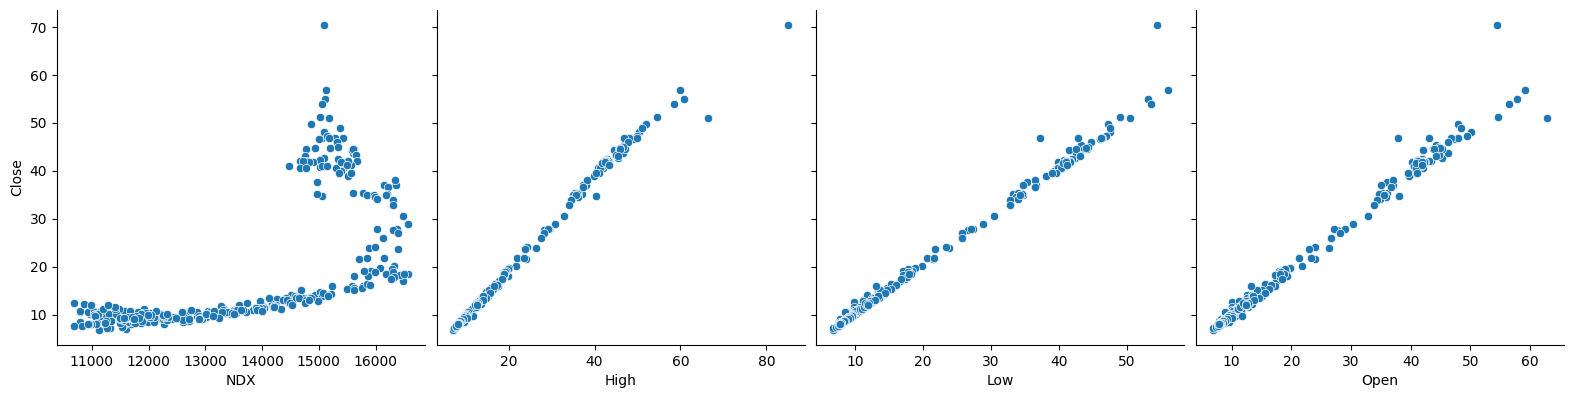

In [9]:
sns.pairplot(data, x_vars=['NDX', 'High', 'Low','Open'], y_vars='Close',height=4, aspect=1, kind='scatter')
plt.show()

Observation : Regressor and regrease ( as in first plot) do not seem to be following linear relationship

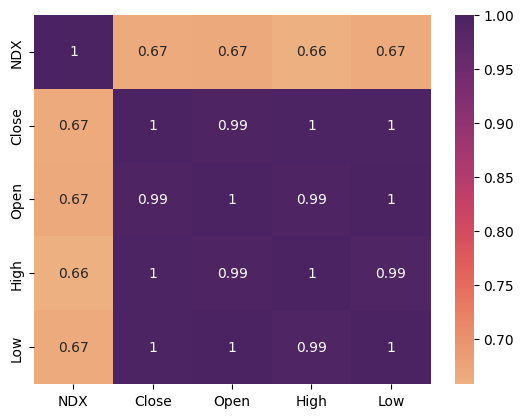

In [10]:
sns.heatmap(data.corr(), cmap="flare", annot = True)
plt.show()

Observation : From above heatmap, we observe a 0.67 corelation between regressor and regrese, which is fairly ok to model

In [11]:
# calculating daily returns and dropping first row which would have NAN value

data['HOOD Daily Return'] = (data['Close'] / data['Close'].shift(1))-1
data['NDX Daily Return'] = (data['NDX'] / data['NDX'].shift(1)) -1
data.dropna()


,NDX,Close,Open,High,Low,HOOD Daily Return,NDX Daily Return
Date,,,,,,,
2021-07-30,14959.900391,35.150002,34.930000,36.98,33.250000,0.009477,-0.005878
2021-08-02,14963.620117,37.680000,35.970001,37.98,35.299999,0.071977,0.000249
2021-08-03,15061.419922,46.799999,37.910999,48.59,37.159000,0.242038,0.006536
2021-08-04,15083.389648,70.389999,54.450001,85.00,54.400002,0.504060,0.001459
2021-08-05,15181.639648,50.970001,62.900002,66.50,50.459999,-0.275891,0.006514
...,...,...,...,...,...,...,...
2022-12-23,10985.450195,7.950000,7.990000,8.00,7.760000,-0.005006,0.002675
2022-12-27,10822.509766,7.700000,7.850000,7.93,7.680000,-0.031447,-0.014832
2022-12-28,10679.339844,7.700000,7.670000,7.81,7.565000,0.000000,-0.013229


Building linear regression model

In [12]:
X = data['HOOD Daily Return'].dropna()
y = data['NDX Daily Return'].dropna()

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100)

In [14]:
X_train.head()

Date
2021-10-27   -0.104372
2022-06-13   -0.099626
2022-03-14   -0.116183
2022-07-14   -0.014354
2022-02-25    0.008688
Name: HOOD Daily Return, dtype: float64

In [15]:
y_train.head()

Date
2021-10-27    0.002500
2022-06-13   -0.079990
2022-03-14   -0.040053
2022-07-14    0.003399
2022-02-25    0.015349
Name: NDX Daily Return, dtype: float64

In [16]:
# Intercept of the regression line is added as constant
X_train_sm = sm.add_constant(X_train)

# Fitting the regression line using Oridary Least Square method
lr = sm.OLS(y_train, X_train_sm).fit()

# Print the regression params
lr.params

const                0.000167
HOOD Daily Return    0.190815
dtype: float64

In [17]:
# Model summary
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:       NDX Daily Return   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     88.71
Date:                Sat, 23 Sep 2023   Prob (F-statistic):           4.46e-18
Time:                        11:43:55   Log-Likelihood:                 636.41
No. Observations:                 237   AIC:                            -1269.
Df Residuals:                     235   BIC:                            -1262.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0002      0.00

Model interpretation : Above model, that gives slope, β of 0.190815 and intercept, α of 0.000167. Model has a poor R -squared. The model expalins only 27.4% of variance dependent variable that's explained by an independent variable. Hence I need to better the model



Model 2 : Modelling via log returns

In [18]:
# calculating log returns
data['Log Returns'] = np.log(1+data['Close'].pct_change()).iloc[1:]
data['Index Log Returns'] = np.log(1+data['NDX'].pct_change()).iloc[1:]


# Preparing data
X = data['Log Returns'].dropna()
y = data['Index Log Returns'].dropna()


# Train data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100)

#Model building
X_train_sm = sm.add_constant(X_train)

# Fitting the regression line using Oridary Least Square method
lr = sm.OLS(y_train, X_train_sm).fit()

# Print the regression params
lr.params




const          0.000194
Log Returns    0.181438
dtype: float64

In [19]:
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:      Index Log Returns   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     80.09
Date:                Sat, 23 Sep 2023   Prob (F-statistic):           1.10e-16
Time:                        11:55:15   Log-Likelihood:                 632.57
No. Observations:                 237   AIC:                            -1261.
Df Residuals:                     235   BIC:                            -1254.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0002      0.001      0.176      

Model interpretation : Model has a poor R -squared. The model expalins only 25.4% of variance dependent variable that's explained by an independent variable. Hence I need to better the model


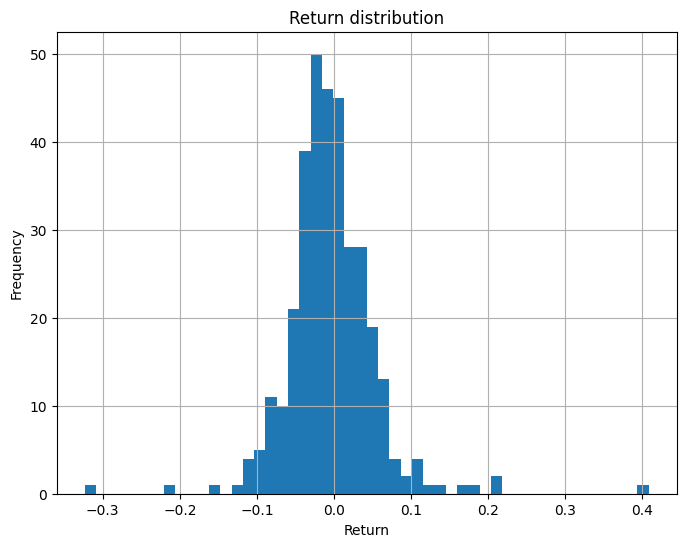

In [20]:
%matplotlib inline
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)
X.hist(bins=50, ax=ax1)
ax1.set_xlabel('Return')
ax1.set_ylabel('Frequency')
ax1.set_title('Return distribution')
plt.show()


Observation : Above plot looks like bell shaped curve. I would try modelling using Normal distribution

Model 3: Normal distribution with daily regular returns

In [21]:
# Calculate moments of normal distrinution
mean = np.mean(data['HOOD Daily Return'])
std_dev = np.std(data['HOOD Daily Return'])
skewness = pd.Series(data['HOOD Daily Return']).skew()
kurtosis  = pd.Series(data['HOOD Daily Return']).kurt()
print('Mean: ', round(mean, 4))
print('Standard Deviation: ', round(std_dev, 4))
print('Skewness: ', round(skewness, 4))
print('Kurtosis: ', round(kurtosis, 4))




Mean:  -0.0026
Standard Deviation:  0.0599
Skewness:  2.0443
Kurtosis:  17.175


Interpretation of moments of normal distribution params :
Mean = -0.0026, indicates, on a average HOOD returned a negative return of 2.6%
Standard Deviation (SD) = 0.0599 shows about 6% variability of daily returns
Skew > 2 shows long right tail, there are more positive returns than negative ones
For a standard normal distribution, mean =0, SD =1, skew =0 and kurtosis =3

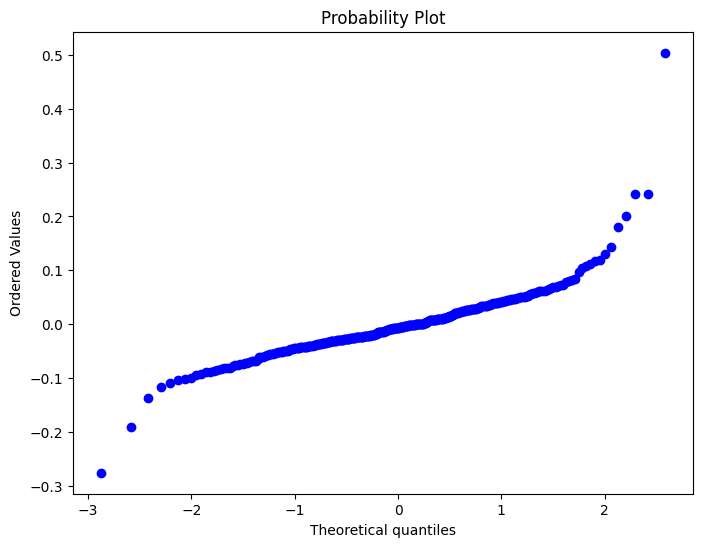

In [22]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
stats.probplot(data['HOOD Daily Return'], dist='norm', plot=ax)
plt.show()



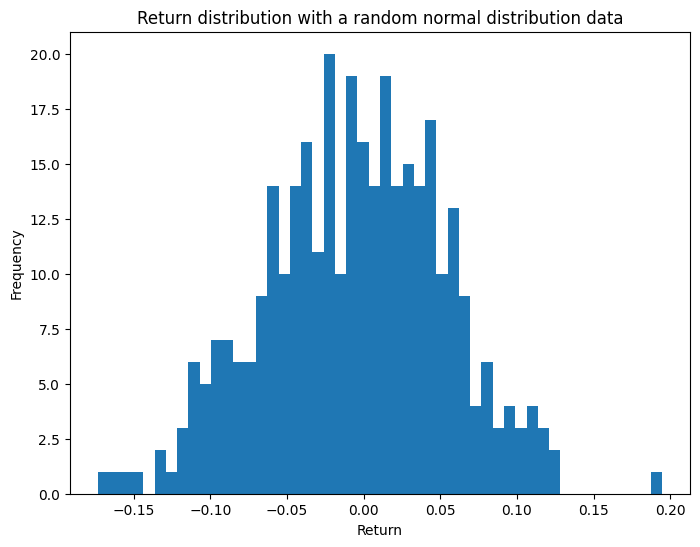

In [23]:
# a random normal distribution with the same mean and standard deviation for HOOD Inc.
normal = np.random.normal(
    loc   = -0.0026, # mean
    scale = 0.0599, # std
    size  = 341, # num
)
fig = plt.figure(figsize=(8,6))
ax5 = fig.add_subplot(1, 1, 1)
ax5.set_xlabel('Return')
ax5.set_ylabel('Frequency')
ax5.set_title('Return distribution with a random normal distribution data')
plt.hist(normal, bins=50)
plt.show()


In [24]:
# Probability of making 1% profit
from scipy.stats import norm
1-stats.norm.cdf(0.01,-0.0026,0.0599)


0.41669702887821625

Conclusion : We observe as per this model, there is only 41.6% chance of making 1% profit in a day

In [25]:
# Probability of making 1% loss
from scipy.stats import norm
1-stats.norm.cdf(-0.01,-0.0026,0.0599)

0.5491599452364652

In [26]:
#Normality of a distribution is checked by kolmogorov smirnov test. It calculates the distance between the empirical(real) and theoretical distributions(ideal) and calculates p value of k static
returns = data['HOOD Daily Return'].dropna()
ks_stat , p_value = stats.kstest(returns , 'norm')
print(ks_stat,p_value)

if p_value > 0.05 :
    print("Gaussian")
else :
    print("not gaussian")

0.44493037662519785 7.18551295048547e-62
not gaussian


Model 4 : Check if the data fits as a log normal distribution

In [28]:
#Normality of a distribution is checked by kolmogorov smirnov test. It calculates the distance between the empirical(real) and theoretical distributions(ideal) and calculates p value of k static
data =data.Close
log_returns = np.log(1+data.pct_change()).iloc[1:]
ks_stat , p_value = stats.kstest(log_returns , 'norm')
print(ks_stat,p_value)

if p_value > 0.05 :
    print("Gaussian")
else :
    print("not gaussian")


0.44207072532200953 4.831232704217796e-61
not gaussian


Conclusion : Data doesnot seem to fit a log ormal distribution from the above results

Model 5 : Monte Carlo Simulation, (MCS) model, daily returns = e^r             
                              r = drift + stdev*z


In [32]:
# Calculating MCS params
u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5*var)
stddev = log_returns.std()


In [36]:
# Building the model at 95% probabaility
x = np.random.rand(10,2)
Z = norm.ppf(np.random.rand(10,2))
t_intervals = 1000
iterations = 20

daily_returns = np.exp(np.array(drift) + np.array(stddev) * norm.ppf(np.random.rand(t_intervals,iterations)))
daily_returns

array([[0.8823654 , 1.00902027, 1.04214094, ..., 1.02168646, 0.9837629 ,
        0.95261559],
       [0.942459  , 1.04860855, 1.00034732, ..., 0.9609788 , 0.95818939,
        1.11899582],
       [0.93025522, 0.94199993, 0.9349747 , ..., 0.9571145 , 0.89867176,
        0.94066653],
       ...,
       [0.96018055, 0.88611962, 0.94467551, ..., 0.99527916, 0.92708858,
        1.00845031],
       [0.98723493, 1.01750829, 0.94550223, ..., 0.95418894, 0.99830252,
        0.9349757 ],
       [0.99255991, 0.90800045, 0.89451977, ..., 1.08135872, 1.03172484,
        1.04423316]])

In [35]:
# Modelling stock price on S1 day from S0 prices
S0 = data.iloc[-1]
S0

8.140000343322754

In [37]:
price_list = np.zeros_like(daily_returns)
price_list[0] = S0
price_list


array([[8.14000034, 8.14000034, 8.14000034, ..., 8.14000034, 8.14000034,
        8.14000034],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [38]:
# Running the simulation in the loop
for t in range(1,t_intervals):
    price_list[t] = price_list[t-1]*daily_returns[t]
price_list

array([[8.14000034e+00, 8.14000034e+00, 8.14000034e+00, ...,
        8.14000034e+00, 8.14000034e+00, 8.14000034e+00],
       [7.67161658e+00, 8.53567393e+00, 8.14282752e+00, ...,
        7.82236777e+00, 7.79966195e+00, 9.10862638e+00],
       [7.13656138e+00, 8.04060428e+00, 7.61333772e+00, ...,
        7.48690163e+00, 7.00933595e+00, 8.56817992e+00],
       ...,
       [5.60575854e-03, 2.99483696e-02, 4.79317119e-02, ...,
        5.42887386e-02, 5.51213680e-03, 1.76464000e-01],
       [5.53420065e-03, 3.04727143e-02, 4.53195403e-02, ...,
        5.18017141e-02, 5.50278008e-03, 1.64989552e-01],
       [5.49302570e-03, 2.76692382e-02, 4.05392250e-02, ...,
        5.60162351e-02, 5.67735488e-03, 1.72287561e-01]])

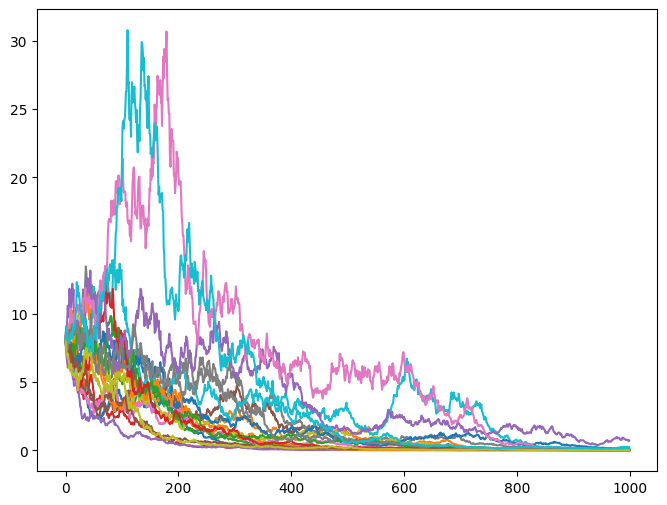

In [39]:
#Plotting the results
plt.figure(figsize=(8,6))
plt.plot(price_list)


In [ ]:
# Calculating Expected price, 5%and 95% quantiles
print('Expected Price: ', round(np.mean(price_list),2))
print('Quantile (5%): ', round(np.percentile(price_list,5)))
print('Quantile (95%): ', round(np.percentile(price_list,95)))

Expected Price:  1.65
Quantile (5%):  0
Quantile (95%):  7


Conclusion 1 : From the above results we can see that after 1000 days ( about 4 years from listing) stock would close $1.65.


Conclusion 2 : From the above results after 1000 days( in about 4 years after listing) stock has 5 % probability of trading above $7


Conclusion 3 : From the above results after 1000 days( in about 4 years after listing) stock has 5 % probability of trading below $0